<h1>WGAN-GP</h1>
Note that the architecture is the same as for my GAN example (ignore this line if you look into this file first),<br/>
but with some smaller changes that make it into a Wasserstein GAN with gradient penality. Everything new is marked with '#NEW#';However, I also removed any conditioning to keep things simple.<br/><br/>
Basic idea: Make sure our discriminator always outputs a useable gradient (=gradient is about ~1 everywhere), hence turning our discriminator<br/>
into a critic: with gradient being about 1, this means that changes in the generator output only slowly change the verdict of the discriminator.<br/>
Without these "sudden" changes, this discriminator is forced to provide a smooth transition (=gradient of 1 for every input) from "fake" to "real",<br/>
meaning it is trained to judge whether some things are "better" or "worse" instead of just training to output "0/1":<br/>
Hence, the bipolar discriminator turns into a critic that can is trained to quantify how good an output is <br/>
<br/>
Literature I recommend:<br/>
1. GAN: https://arxiv.org/abs/1406.2661<br/>
2. Wasserstein GAN: https://arxiv.org/abs/1701.07875<br/>
3. Wasserstein GAN, but with gradient penalty (as we use here): https://arxiv.org/abs/1704.00028<br/>
<br/>
(original WGAN paper ensures our discriminator is smooth enough by saying: If we interpret our network as a polynomial, then we can limit the rate of change by limiting the maximum allowed weight, i.e. by clipping weights above a threshold; with limited range of change, we neither have these "sudden changes" in output verdict to switch from "fake" to "real", hence having a smooth transition from "fake" to "real" - just as we want our generator to have)

<h2>1. Imports</h1>

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt

<h2>2. Global definitions & helpers</h1>

In [ ]:
Z_DIMS = 64 #number of random values to put into our GAN
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPSILON = 1e-8

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)

def show(img):
    assert(len(img.size()) == 3)
    plt.imshow(img.clamp(-1.0,1.0).squeeze(), cmap='gray')
    plt.show()
for img, label in train_loader:
    #show example image:
    show(img[0])
    break

<h2>3. Network architecture </h1>

In [ ]:
#trivial risidual block: apply convolution twice, then add the original input projected to the output size
#tl;dr "do some computation, then add the original input to the result to make sure our gradients are somewhat stable and we train without vanishing gradients"
class ResBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, skip_last_relu=False):
        super(ResBlock, self).__init__()
        #without bias & with kernel size 1, this is effectively just "projecting" the input to the output size without doing much. this can also scale that residual just to zero if we want
        self.conv_res = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, stride=1, bias=False)

        self.conv_1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.conv_2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1)
        #leaky relu = better gradient flow / prevention of "dead" neurons that do not change anymore
        self.relu_1 = torch.nn.LeakyReLU(negative_slope=0.01) #slope 0.01 basically means: "max(x, 0.01 * x)", i.e. if we are < 0, then we do not clamp to 0, but to 0.01 * x (e.g. -5 gets clamped to -0.05)
        self.relu_2 = torch.nn.LeakyReLU(negative_slope=0.01)
        if skip_last_relu:
            #our target values we want to generate are between [-1, 1] - applying (leaky) relu would basically (soft) clamp us to [0, inf);
            #hence, in those cases, just do nothing. that's faster than some ugly "if"-branch in the forward method
            self.relu_2 = torch.nn.Identity()
    
    def forward(self, x):
        x_res = self.conv_res(x)
        
        x = self.relu_1(self.conv_1(x))
        x = self.relu_2(self.conv_2(x))
        x = x + x_res
        return x

#simple generator: take random noise, process it a bit ("let the generator decide on what it should generate"), then upscale/residual block it until we reach target size
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #first part: generate a 7x7 base image from random noise
        self.lin_res = torch.nn.Linear(Z_DIMS, 16*7*7, bias=False)
        self.lin_1 = torch.nn.Linear(Z_DIMS, 128)
        self.lin_2 = torch.nn.Linear(128, 128)
        self.lin_3 = torch.nn.Linear(128, 16*7*7)

        #second part: alternate between residual blocks and upscaling until we reach target size
        self.res_1 = ResBlock(16, 64)
        self.res_2 = ResBlock(64, 64)
        self.res_3 = ResBlock(64, 1, skip_last_relu=True) #don't apply a relu at the end: we output images with values between [-1, 1], applying a relu would clamp us to [0, inf)

        #we use upsclaing, because transposed convolution layers create some ugly artifacts: https://distill.pub/2016/deconv-checkerboard/
        #just dumb upscaling and then applying a convolution layers does the same trick, just without artifacts
        self.upscale = torch.nn.Upsample(scale_factor=2.0, mode='bilinear')

        self.relu = torch.nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        #take input vector, then project it to [b x 1 x 7 x 7]
        x_res = self.lin_res(x)
        x = self.relu(self.lin_1(x))
        x = self.relu(self.lin_2(x))
        x = self.relu(self.lin_3(x))
        x = x + x_res
        #re-shape so we have a [b x 16 x 7 x 7] tensor ("tiny" image with some channels)
        x = x.view(x.size()[0], 16, 7, 7)
        #second part: alternate between residual blocks and upscaling until we reach target size
        x = self.res_1(x)
        x = self.upscale(x)
        # now at [b x 64 x 14 x 14]
        x = self.res_2(x)
        x = self.upscale(x)
        # now at [b x 64 x 28 x 28]
        x = self.res_3(x)
        # now at [b x 1 x 28 x 28]
        return x

#simple critic: take an image, process it with a CNN, then output a value in [-inf, inf],
#rating HOW GOOD an input is instead of learning a binary classification (real/fake) as we'd do for a discriminator
#basically, the generator architecture in reverse: interleave residual blocks and downscaling, then process with linear layers when information is dense enough
#(same as for regular GAN example, just named differently)
class Critic(torch.nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        #first part: process the image with our convolutional residual blocks
        self.res_1 = ResBlock(1, 64) #process image(1) and label embedding(8)
        self.res_2 = ResBlock(64, 64)
        self.res_3 = ResBlock(64, 16)
        self.downscale = torch.nn.Upsample(scale_factor=0.5, mode='bilinear') #same reason as for the upscaling: if we use convolutional layers, we get ugly artifacts. this is basically just avg pooling now
        #second part: process the image with linear layers
        self.lin_1 = torch.nn.Linear(16*7*7, 128)
        self.lin_2 = torch.nn.Linear(128, 128)
        self.lin_3 = torch.nn.Linear(128, 1)
        #for leaky relu here, use a slope of 0.1, because that gives us a bit more stable gradients:
        #the decision isn't as "harsh", hence the generator has an easier time to fix it's mistakes
        #(easier to "learn" the correct direction, i.e. if generator outputs are still wrong, but less wrong) 
        self.relu = torch.nn.LeakyReLU(negative_slope=0.1)

    def forward(self, x):
        #first part: process the image with our convolutional residual blocks
        x = self.res_1(x)
        x = self.downscale(x)
        # now at [b x 64 x 14 x 14]
        x = self.res_2(x)
        x = self.downscale(x)
        # now at [b x 64 x 7 x 7]
        x = self.res_3(x)
        # now at [b x 16 x 7 x 7]
        x = x.view(x.size()[0], 16*7*7)
        #second part: process the image with linear layers; could also skip this part, giving us basically a patch-wise discriminator as done by many papers!
        x = self.relu(self.lin_1(x))
        x = self.relu(self.lin_2(x))
        x = self.lin_3(x) #no activation at the end - then we can get values in [-inf, inf]
        return x

<h2>4. Training and inference</h1>

The generator has  301979  parameters
The critic has  245281  parameters
*** DONE WITH EPOCH 0  ***
	AVG loss discriminator:  -250.41908834397793
	AVG loss generator    :  69.34565829277038


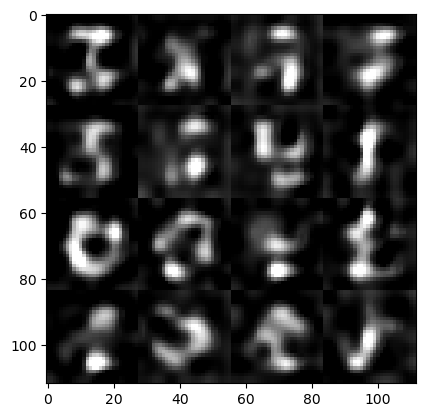

*** DONE WITH EPOCH 1  ***
	AVG loss discriminator:  -104.84078308105468
	AVG loss generator    :  41.25334396034479


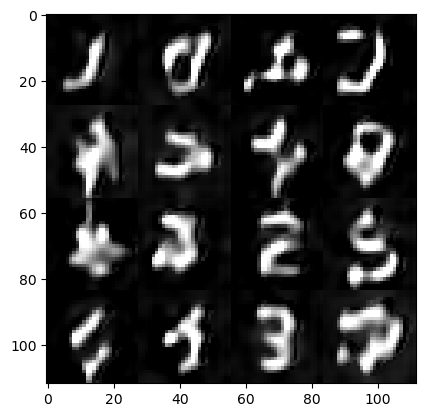

*** DONE WITH EPOCH 2  ***
	AVG loss discriminator:  -80.64828649520874
	AVG loss generator    :  27.965353236198425


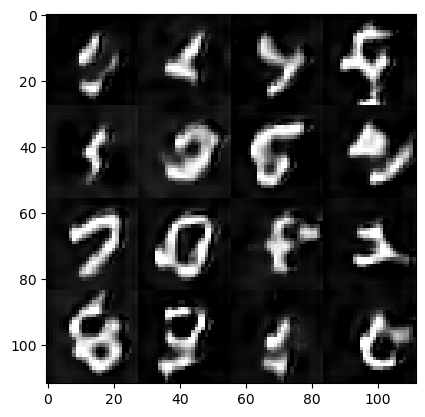

*** DONE WITH EPOCH 3  ***
	AVG loss discriminator:  -67.98462286949157
	AVG loss generator    :  -10.826188431978226


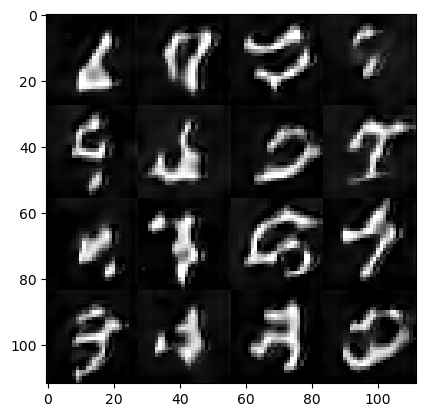

*** DONE WITH EPOCH 4  ***
	AVG loss discriminator:  -58.00048375606537
	AVG loss generator    :  -39.01928319633007


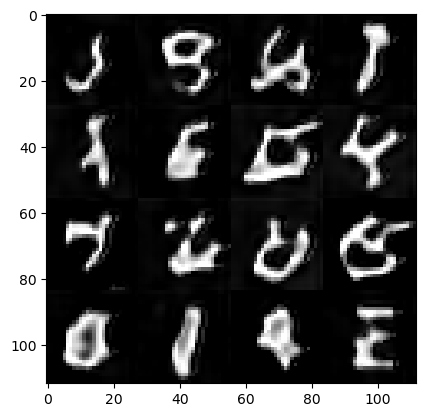

*** DONE WITH EPOCH 5  ***
	AVG loss discriminator:  -57.121942439079284
	AVG loss generator    :  -26.205917151868345


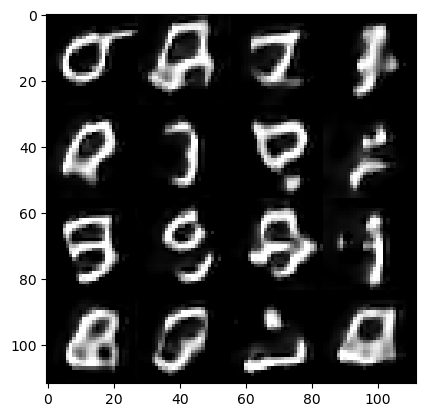

*** DONE WITH EPOCH 6  ***
	AVG loss discriminator:  -55.71987921237945
	AVG loss generator    :  -26.530335417687894


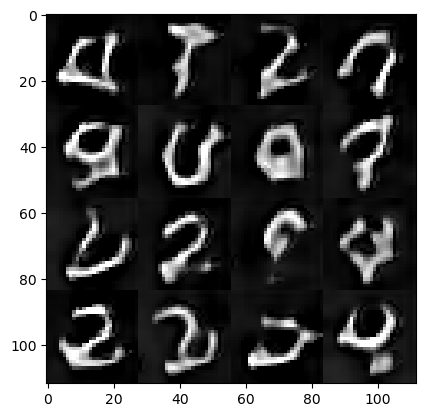

*** DONE WITH EPOCH 7  ***
	AVG loss discriminator:  -54.742265167236326
	AVG loss generator    :  10.664556652009487


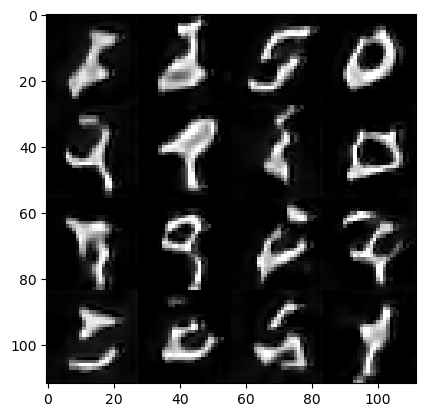

*** DONE WITH EPOCH 8  ***
	AVG loss discriminator:  -51.240360903739926
	AVG loss generator    :  -0.38028638273477555


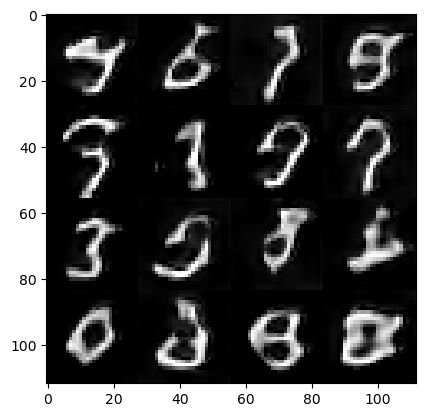

KeyboardInterrupt: 

In [12]:
#initialize the generator and critic
generator = Generator().to(DEVICE)
critic = Critic().to(DEVICE)


print("The generator has ", sum([p.numel() for p in generator.parameters()]), " parameters")
print("The critic has ", sum([p.numel() for p in critic.parameters()]), " parameters")

gen_opt = torch.optim.Adam(generator.parameters(), lr=0.001)
critic_opt = torch.optim.Adam(critic.parameters(), lr=0.001)

hard_relu = torch.nn.ReLU()

#NEW#
#the gradient penalty enforcing the 1-lipschitz constraint:
#   make sure that any inputs (here: random interpolations between real and fake images)
#   have a gradient of 1, meaning the critic has no "rapid" changes in it's rating nor 
#   has a "dead" region where it does not change at all (i.e. the generator can't learn anything)
def gradient_penalty(critic, real, fake):
    #get random interpolations between real and fake images, which is the region where we
    #apply our regularisation (examplary, because we can't regularise that for EVERY possible input)
    alpha = torch.rand((real.size()[0], 1, 1, 1), device=DEVICE) #interpolation variable
    input_data = alpha * real + (1.0 - alpha) * fake
    #make sure we can compute the gradient for our input
    input_data = torch.autograd.Variable(input_data, requires_grad=True)

    #get the actual gradients:
    out = critic(input_data)
    
    gradients = torch.autograd.grad(outputs=out, inputs=input_data, grad_outputs=torch.ones(out.size(), device=DEVICE), create_graph=True)[0]
    #we have gradients for every pixel/channel now
    #get the norm of the gradients per pixel
    gradients = (gradients.view(gradients.size()[0], -1).square().sum(dim=1) + EPSILON).sqrt()
    #every pixel should have a gradient norm close to 1:
    return (1.0 - gradients).square().mean()

for epoch in range(0, 1000):
    step = 0
    loss_disc = 0
    loss_gen = 0
    for real, _ in train_loader:
        #1. put stuff on the GPU
        real = real.to(DEVICE)
        
        noise = torch.rand(real.size()[0], Z_DIMS, device=DEVICE) * 2.0 - 1.0 #noise in [-1, 1] is most stable
        
        #2. train the critic
        for i in range(0, 5): #NEW# not necessary, but we can train the critic more often than the generator now, as it can't "run away"
            critic.train(True)
            generator.train(False)
            critic_opt.zero_grad()
            #detach the generator output, so we do not backpropagate through the generator - 
            #we want to train the discriminator to distinguish between real and fake images, not to find some loopwhole in the generator
            fake = generator(noise).detach() 
            out_real = critic(real).mean()
            out_fake = critic(fake).mean()

            #NEW#
            #this is the wasserstein loss:
            #   a) rate "real" images as high as possible
            #   b) rate "fake" images as low as possible
            #   c) make sure our critic is a 1-lipschitz function, i.e. does not change "more rapidly" than one.
            #      in practise: we just say "gradient should be 1 everywhere", which we regularise (examplary, because we can't do that everywhere)
            #      for random interpolations between real and fake pieces of data.
            #      alternatively, we could also just "clip" the weights to e.g. 0.01, but that's not as nice as the gradient penalty
            #      weight clipping has the idea to limit the complexity of the critic's learned function, hence preventing these "rapid changes"
            #      which instead enforces the 1-lipschitz constraint (gradually improve the critic's rating as the input gets better)
            loss = -out_real + out_fake + gradient_penalty(critic, real, fake)
            loss_disc += loss.item()
            loss.backward()
            critic_opt.step()
        #3. train the generator
        if True:
            critic.train(False)
            generator.train(True)
            gen_opt.zero_grad()

            fake = generator(noise)
            out_fake = critic(fake).mean()
            #train the generator to "fool" the discriminator: output should be judged to be as high as possible (=critic says real)
            #NEW#
            loss = -out_fake
            loss_gen += loss.item()
            loss.backward()
            gen_opt.step()
        
        step += 1
        if step == 100: #don't wait for the whole dataset, we want to see stuff quickly...
            break

    print('*** DONE WITH EPOCH',epoch,' ***')
    #as discriminator output is unbounded and only guided by the regularisation of the gradient penalty, we can't really interpret the loss values here!!!
    print("\tAVG loss discriminator: ", loss_disc/step)
    print("\tAVG loss generator    : ", loss_gen /step)
    #show some example images
    with torch.no_grad():
        generator.eval()
        noise = torch.rand(16, Z_DIMS, device=DEVICE) * 2.0 - 1.0
        fake = generator(noise).cpu()
        #form of [16 x 1 x 28 x 28] - plot as 4x4 grid
        out = torch.zeros(1, 4*28, 4*28)
        #dumb loop is slow, but we don't care for just the output here
        for x in range(0, 4):
            for y in range(0, 4):
                out[0, x*28:(x+1)*28, y*28:(y+1)*28] = fake[x*4+y, 0]
        show(out)